## FERC <> EIA Granular Connections

Notes on the type of problem we are trying to solve:
- A classification problem
    - A Multi-Class Classification problem*
- A deterministic problem
- A record linkage problem

Right now, we are using the recordlinkage package. We're using logistic regression classifier because it fits all of the above.

What we still need:
- determine how to restrict the results to one eia record per ferc record! - DONE (with more fine tuning to come)
- Remove false granularities in the MUL - DONE
    - Partent/Child granularities - DONE
    - Peer/peer granularities - DONE
- fine tune the comparison metric for heat rate and total fuel cost. (Issue #22)
- add in additional FERC tabels (Issue #21)
- more test data!
- so, so much more.

To consider:
- Maybe we want to run the records with fuel cost data through a different matching model...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
from copy import deepcopy
import scipy

import yaml

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [5]:
sys.path.append("../")
from pudl.output.ferc1 import *
from ferc_eia_connections import *
from plant_part_agg_eia import *
from plant_parts import plant_parts
import ferc_eia_connections
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

### Pull in data (EIA, FERC and training)

In [6]:
table_compiler = CompileTables(pudl_engine, freq='AS', rolling=True)

In [7]:
parts_compilers = CompilePlantParts(table_compiler, clobber=True)

In [8]:
plant_parts_df = parts_compilers.generate_master_unit_list(plant_parts)
plant_parts_df = plant_parts_df[plant_parts_df['false_gran'] != True]

beginning the aggregation for generators_eia860
grabbing generators_eia860 from the sqlite db
Converting the dtypes of: generators_eia860
beginning the aggregation for generation_eia923
grabbing generation_eia923 from the sqlite db
Converting the dtypes of: generation_eia923
beginning the aggregation for mcoe
grabbing mcoe from the output object
filling in fuel cost NaNs with rolling averages
Converting the dtypes of: mcoe
grabbing ownership_eia860 from the sqlite db
Converting the dtypes of: ownership_eia860
begin aggregation for: plant_prime_fuel
denormalize plant_prime_fuel
grabbing generators_entity_eia from the sqlite db
Converting the dtypes of: generators_entity_eia
grabbing boiler_generator_assn_eia860 from the sqlite db
Converting the dtypes of: boiler_generator_assn_eia860
begin aggregation for: plant_technology
denormalize plant_technology
begin aggregation for: plant_prime_mover
denormalize plant_prime_mover
begin aggregation for: plant_gen
begin aggregation for: plant_unit

In [9]:
# compliers for training data
compiler_train = ferc_eia_connections.TrainXlxsCompiler()

In [10]:
train_df_ids = ferc_eia_connections._prep_train_connections(parts_compilers,compiler_train)

grabbing xlxs file.


In [11]:
# pudl output object for ferc data
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS')

In [12]:
steam_cleaned = ferc_eia_connections._prep_ferc_data(pudl_out)

Converting the dtypes of: ferc1 plant records


### Generate known test datasets

In [13]:
# generate the list of the records in the EIA and FERC records that exist
# in the training data
eia_known = (plant_parts_df.merge(train_df_ids.reset_index().drop(columns=['record_id_ferc'])[['record_id_eia']],
                          left_index=True,
                          right_on=['record_id_eia']).
            drop_duplicates(subset=['record_id_eia']).
            set_index('record_id_eia').
            astype({'total_fuel_cost':float,
                    'total_mmbtu':float}))

ferc_known = (steam_cleaned.merge(train_df_ids.reset_index().drop(columns=['record_id_eia'])[['record_id_ferc']],
                          left_index=True,
                          right_on=['record_id_ferc']).
             drop_duplicates(subset=['record_id_ferc']).
             set_index('record_id_ferc').
             astype({'total_fuel_cost':float,
                     'total_mmbtu':float}))

# Omigosh the actual Matching

In [14]:
import statistics

In [41]:
dfA_known = ferc_known
dfB_known = eia_known
dfA = steam_cleaned[steam_cleaned['report_year'] == 2018]
dfB = plant_parts_df[plant_parts_df['report_year'] == 2018]

In [42]:
print(dfA_known.shape)
print(dfB_known.shape)
print(dfA.shape)
print(dfB.shape)

(193, 20)
(260, 29)
(640, 20)
(13259, 29)


#### Making Comparison Feature Vectors

In [43]:
features_all = ferc_eia_connections.make_features(dfA, dfB, block_col='plant_id_report_year')
features_known = ferc_eia_connections.make_features(dfA_known, dfB_known, block_col='plant_id_report_year')

In [35]:
# features_all.describe().T

In [36]:
# features_known.describe().T

### Classificaiton Models

In [44]:
import recordlinkage as rl
import warnings
warnings.filterwarnings('ignore')

In [53]:
%%time
# this cell takes a fair amount of time (> 2 minutes on my computer)
# it is testing an array of model hyper parameters and 
# cross-vaildating with the training data. It returns a df with losts
# of result scores to be used to find the best resutls
results_options = ferc_eia_connections.test_model_parameters(
    features_known, train_df_ids.index, 10)

CPU times: user 2min 11s, sys: 1.26 s, total: 2min 12s
Wall time: 2min 41s


In [22]:
results_options = results_options.sort_values(['f_score','precision','accuracy'],ascending=False)
best = results_options.head(1)

In [25]:
prediction_df = fit_predict_lrc(best,features_known, train_df_ids)

In [26]:
coefs = best['coef'].values[0]
weighted_feats_all = weight_features(features_all,coefs)
feats_all = calc_match_stats(weighted_feats_all)

results_weighted = weight_features(prediction_df,coefs)
results = calc_match_stats(results_weighted)
results = results.merge(feats_all[['iqr']],left_index=True,right_index=True,how='left',suffixes=("","_all"))

In [27]:
winners = calc_wins(results, dfA)

matches vs total ferc:  0.89
wins vs total ferc:     0.82
wins vs matches:        0.92
murk vs matches:        0.07
ties vs matches:        0.01


In [34]:
# these are... the winners.
winners

,,score,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,total_fuel_cost,total_mmbtu,utility_id_pudl,diffs,count,rank,iqr,iqr_all
record_id_ferc,record_id_eia,,,,,,,,,,,,,,,,
f1_steam_2018_12_100_0_1,55220_2018_plant_total_12685,41.641356,3.118688,2.626918e+00,-2.810300,-1.450578,1.040608,-0.174525,5.063623e-03,3.427015e+01,3.349843e-12,5.015332,NaN,1,1.0,0.000000,0.000000
f1_steam_2018_12_100_0_2,2050_2018_plant_total_12685,7.380313,3.120382,2.626918e+00,-2.759465,-1.450578,0.995393,-0.174525,6.852641e-03,1.590387e-06,6.950553e-95,5.015332,NaN,1,1.0,0.000000,0.000000
f1_steam_2018_12_100_0_3,8054_2018_plant_total_12685,7.270765,3.117417,2.626918e+00,-2.772042,-1.450578,0.902724,-0.174525,8.682914e-06,5.510079e-03,1.335023e-128,5.015332,NaN,1,1.0,0.000000,0.000000
f1_steam_2018_12_100_0_4,55218_2018_plant_total_12685,5.908177,3.037784,8.737542e-02,-2.811206,-1.450578,1.049744,-0.174525,1.025994e+00,1.282565e-01,7.493323e-101,5.015332,NaN,1,1.0,0.000000,0.000000
f1_steam_2018_12_100_1_1,2053_2018_plant_total_12685,103.299636,3.119705,2.626918e+00,-2.757011,-0.000000,0.836401,-0.174525,1.818321e-01,9.445098e+01,9.685428e-66,5.015332,NaN,1,1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f1_steam_2018_12_99_0_1,6073_2018_plant_total_12686,5.007893,2.645517,6.665459e-51,-2.700427,-0.000000,0.047471,-0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.015332,NaN,3,1.0,3.199784,3.457049
f1_steam_2018_12_99_0_3,2049_2018_plant_total_12686,6.828764,3.075349,3.241964e-07,-2.413344,-1.450578,0.900462,-0.174525,1.876066e+00,1.890205e-153,0.000000e+00,5.015332,NaN,1,1.0,0.000000,0.000000
f1_steam_2018_12_99_0_4,2049_2018_plant_total_12686,4.459422,2.954131,1.227612e-35,-2.059464,-1.450578,0.000000,-0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.015332,NaN,1,1.0,0.000000,0.000000


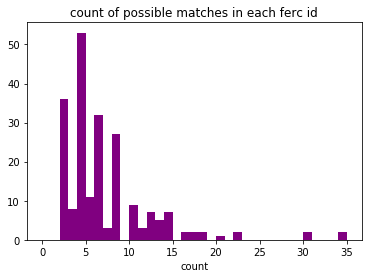

In [29]:
plt.hist(feats_all[feats_all['count'] != 1].reset_index().drop_duplicates(subset=['record_id_ferc'])['count'],
         #weights=weights_part,
         range=(0,35),
         bins=35,
         color="purple",
         #label=f'{part_name}'
        )

plt.title(f'count of possible matches in each ferc id')
plt.xlabel('count')
plt.ylabel(None)
#plt.legend()
plt.show()

In [30]:
def plot_all_hist(all_df,results_df,winners_df, range):
    if all_df is not None:
        plt.hist(all_df['score'], 
                 range=range,
                 bins=100,
                 color="pink",
                 label='all options'
                )
    if results_df is not None:
        plt.hist(results_df['score'], 
                 range=range,
                 bins=100,
                 color="purple",
                 label='all results'
                )
    if winners_df is not None:
        plt.hist(winners_df['score'], 
                 range=range,
                 bins=100,
                 color="turquoise",
                 label='winning options'
                )


    plt.title(f'weighted score of comparision features')
    plt.xlabel('weighted sum')
    plt.ylabel(None)
    plt.legend()
    plt.show()

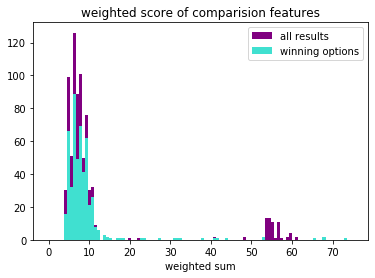

In [31]:
plot_all_hist(None,results,winners,range=(0,75))

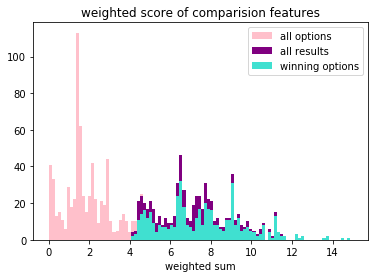

In [32]:
plot_all_hist(feats_all,results,winners, range=(0,15))

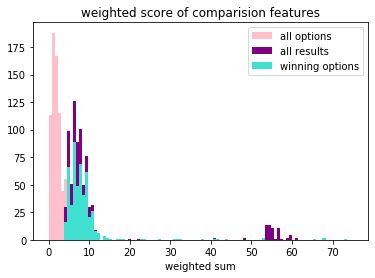

In [33]:
plot_all_hist(feats_all,results,winners, range=(0,75))